# Convolutional Neural Networks

## Project: Write an algorithm to classify dog breed with CNN (from scratch) and Inception_v3 model (transfer learning) 

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [5]:
# !unzip dogImages.zip
# !unzip lfw.zip
# !unzip haarcascades.zip

In [ ]:
# data_dir = 'Cat_Dog_data'

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


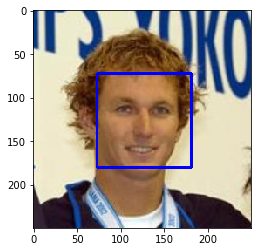

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[4])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_face = []
dog_face = []

for i in tqdm(range(len(human_files_short))):
    # Human face
    img_human = face_detector(human_files_short[i])
    human_face.append(img_human)
    # Dog face
    img_dog = face_detector(dog_files_short[i])
    dog_face.append(img_dog)

# Correct prediction (%) - human
correct_human = sum(human_face) / len(human_face)
print('percentage of the first 100 images in human_files have a detected human face', correct_human)
# Incorrect prediction (%) - dog
incorrect_dog = sum(dog_face) / len(dog_face)
print('percentage of the first 100 images in dog_files have a detected human face', incorrect_dog)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:09<00:00, 10.31it/s]

percentage of the first 100 images in human_files have a detected human face 0.96
percentage of the first 100 images in dog_files have a detected human face 0.18


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [5]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    
# print(VGG16)

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](https://pytorch.org/vision/stable/models.html).

In [7]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    # load image
    img = Image.open(img_path)
    
    # VGG-16 Takes 224x224 images as input, so we resize all of them
    data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                          transforms.ToTensor()])
    # apply transform
    img_transform = data_transform(img).unsqueeze(0)

    if use_cuda:
      img_transform = img_transform.cuda()
    
    # set VGG-16 model in eveluation mode
    VGG16.eval()
    
    # get pretrained weight
    #weights = VGG16_Weights.IMAGENET1K_V1.DEFAULT
    # initialize weight inference
    #preprocess = weights.transforms()
    # Apply preprocessing transform
    #img_preprocess = preprocess(img).unsqueeze(0)
    
    # Use the VGG-16 model and print the predicted category
    prediction = VGG16(img_transform).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    # category_name = weights.meta["categories"][class_id]
    # print(f"{category_name}: {100 * score:.1f}%")
    
    ## Return the *index* of the predicted class for that image
    
    return class_id # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    # prediction using VGG-16
    pred_dog = VGG16_predict(img_path)
    
    # If class_id is between 151-268 inclusive, confirms dog is predicted
    if 151 <= pred_dog <= 268:
        return True
    else:
        return False   # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [9]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_face = []
dog_face = []

for i in tqdm(range(len(human_files_short))):
    # Human face
    img_human = dog_detector(human_files_short[i])
    human_face.append(img_human)
    # Dog face
    img_dog = dog_detector(dog_files_short[i])
    dog_face.append(img_dog)

# Correct prediction (%) - human
incorrect_human = sum(human_face) / len(human_face)
print('percentage of the first 100 images in human_files have a detected dog face - VGG16', incorrect_human)
# Incorrect prediction (%) - dog
correct_dog = sum(dog_face) / len(dog_face)
print('percentage of the first 100 images in dog_files have a detected dog face - VGG16', correct_dog)

100%|██████████| 100/100 [00:39<00:00,  2.52it/s]

percentage of the first 100 images in human_files have a detected dog face - VGG16 0.0
percentage of the first 100 images in dog_files have a detected dog face - VGG16 0.9


In [ ]:
# print(human_face)
# print(dog_face)

We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [10]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

## Try Inception_v3 pretrained model

# Import model
# define Inception-v3 
inception_v3 = models.inception_v3(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    inception_v3 = inception_v3.cuda()
    
# print(inception_v3)

In [11]:
### (Optional) - Inception V3

def inception_v3_predict(img_path):
    '''
    Use pre-trained inception_v3 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    # load image
    img = Image.open(img_path)
    
    # Rransform data
    data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                          transforms.ToTensor()])
    # apply transform
    img_transform = data_transform(img).unsqueeze(0)

    if use_cuda:
      img_transform = img_transform.cuda()
    
    # setInception-v3 model in evaluation mode
    inception_v3.eval()
    
    # get pretrained weight
    #weights = VGG16_Weights.IMAGENET1K_V1.DEFAULT
    # initialize weight inference
    #preprocess = weights.transforms()
    # Apply preprocessing transform
    #img_preprocess = preprocess(img).unsqueeze(0)
    
    # Use the Inception-v3 model and print the predicted category
    prediction = inception_v3(img_transform).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    # category_name = weights.meta["categories"][class_id]
    # print(f"{category_name}: {100 * score:.1f}%")
    
    ## Return the *index* of the predicted class for that image
    
    return class_id # predicted class index

In [12]:
### (Optional) - Inception V3

### returns "True" if a dog is detected in the image stored at img_path
def dog_detector_inception_v3(img_path):
    ## TODO: Complete the function.
    # prediction using inception_v3
    pred_dog = inception_v3_predict(img_path)
    
    # If class_id is between 151-268 inclusive, confirms dog is predicted
    if 151 <= pred_dog <= 268:
        return True
    else:
        return False   # true/false

In [13]:
### (Optional) - Inception V3

### TODO: Test the performance of the dog_detector_inception_v3 function
### on the images in human_files_short and dog_files_short.

human_face = []
dog_face = []

for i in tqdm(range(len(human_files_short))):
    # Human face
    img_human = dog_detector_inception_v3(human_files_short[i])
    human_face.append(img_human)
    # Dog face
    img_dog = dog_detector_inception_v3(dog_files_short[i])
    dog_face.append(img_dog)

# Correct prediction (%) - human
incorrect_human = sum(human_face) / len(human_face)
print('percentage of the first 100 images in human_files have a detected dog face - Inception V3', incorrect_human)
# Incorrect prediction (%) - dog
correct_dog = sum(dog_face) / len(dog_face)
print('percentage of the first 100 images in dog_files have a detected dog face - Inception V3', correct_dog)

100%|██████████| 100/100 [00:14<00:00,  6.94it/s]

percentage of the first 100 images in human_files have a detected dog face - Inception V3 0.03
percentage of the first 100 images in dog_files have a detected dog face - Inception V3 0.91


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you want to attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [14]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets

# define training, validation and test data directories
data_dir = 'dogImages/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

## Specify appropriate transforms, and batch_sizes
# define data transform and augmentation
data_transform = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.RandomRotation(30),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor()])

# Create dataset folder        
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# define dataloader parameters
batch_size = 32
num_workers=0

# prepare data loaders

def loaders_scratch(img_set):
    if img_set == 'train':
        batch_loaders = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
    elif img_set == 'valid':
        batch_loaders = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
    else: 
        batch_loaders = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
    return batch_loaders



# train_loaders = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
#                                            num_workers=num_workers, shuffle=True)
# valid_loaders = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
#                                            num_workers=num_workers, shuffle=True)
# test_loaders = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
#                                           num_workers=num_workers, shuffle=True)

(32, 3, 224, 224)

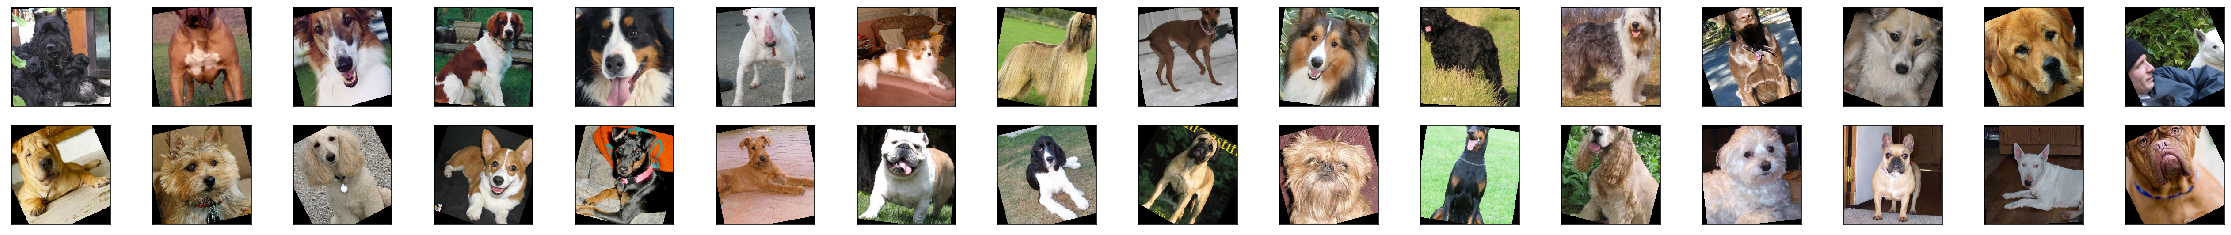

In [15]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(loaders_scratch('test'))
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(40, 4))
for idx in np.arange(32):
    ax = fig.add_subplot(2, 32/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
#    ax.set_title(classes[labels[idx]])

images.shape

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer 1_1 (sees 224x224x3 image tensor; output: 224x224x16)
        self.conv1_1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer 1_2 (sees 224x224x16 image tensor; output: 224x224x16)
        self.conv1_2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer 2_1 (sees 112x112x16 image tensor; output: 112x112x32)
        self.conv2_1 = nn.Conv2d(32, 48, 3, padding=1)
        # convolutional layer 2_2 (sees 112x112x32 image tensor; output: 112x112x32)
        self.conv2_2 = nn.Conv2d(48, 64, 3, padding=1)
        # convolutional layer 3_1 (sees 56x56x32 image tensor; output: 56x56x64)
        self.conv3_1 = nn.Conv2d(64, 80, 3, padding=1)
        # convolutional layer 3_2 (sees 56x56x64 image tensor; output: 56x56x64)
        self.conv3_2 = nn.Conv2d(80, 96, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # linear layer (96 * 28 * 28 -> 6272)
        self.fc1 = nn.Linear(96 * 28 * 28, 6272)
        # linear layer (6272 -> 784)
        self.fc2 = nn.Linear(6272, 784)
        # linear layer (784 -> 133)
        self.fc3 = nn.Linear(784, 133)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        
        # max pooling layer
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        # 1st convolutional layers
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        # max pool layer
        x = self.pool(x)
        
        # 2nd convolutional layers
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        # max pool layer
        x = self.pool(x)
        
        # 3rd convolutional layers
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        # max pool layer
        x = self.pool(x)
        
        # flatten image input
        x = x.view(-1, 96 * 28 * 28)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer,
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer,and softmax function
        x = self.fc3(x)
        # add softmax function
        x = self.softmax(x)
        
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    
    
print(model_scratch)


# Specify model transfer architecture 
# Define Inception-v3 model - import afresh
inception_v3 = models.inception_v3(pretrained=True)
model_transfer = inception_v3

Net(
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(64, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(80, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=75264, out_features=6272, bias=True)
  (fc2): Linear(in_features=6272, out_features=784, bias=True)
  (fc3): Linear(in_features=784, out_features=133, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (softmax): LogSoftmax(dim=1)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [17]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [19]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in tqdm(enumerate(loaders('train'))):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            ## find the loss and update the model parameters accordingly
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            if model == model_transfer:
                loss = criterion(output.logits, target)
            else:
                loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in tqdm(enumerate(loaders('valid'))):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
    # return trained model
    return model


# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

0it [00:00, ?it/s]

209it [20:32,  5.90s/it]
27it [01:21,  3.03s/it]


Epoch: 1 	Training Loss: 16241.349609 	Validation Loss: 4082.976967
Validation loss decreased (inf --> 4082.976967).  Saving model ...


209it [21:31,  6.18s/it]
27it [01:00,  2.24s/it]


Epoch: 2 	Training Loss: 16236.946289 	Validation Loss: 4082.072360
Validation loss decreased (4082.976967 --> 4082.072360).  Saving model ...


<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [20]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in tqdm(enumerate(loaders('test'))):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

27it [01:06,  2.47s/it]

Test Loss: 4.887742


Test Accuracy:  1% (10/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [21]:
## TODO: Specify data loaders

## Specify appropriate transforms, and batch_sizes
# define data transform and augmentation
data_transform_transfer = transforms.Compose([transforms.Resize(512),
                                     transforms.CenterCrop(299),
                                     transforms.RandomRotation(30),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor()])

# Create dataset folder        
train_data = datasets.ImageFolder(train_dir, transform=data_transform_transfer)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform_transfer)
test_data = datasets.ImageFolder(test_dir, transform=data_transform_transfer)

# define dataloader parameters
batch_size = 32
num_workers=0

# prepare data loaders

def loaders_transfer(img_set):
    if img_set == 'train':
        batch_loaders = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
    elif img_set == 'valid':
        batch_loaders = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
    else: 
        batch_loaders = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
    return batch_loaders


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [22]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
# Define Inception-v3 model - import afresh
inception_v3 = models.inception_v3(pretrained=True)
model_transfer = inception_v3

# Freeze parameters so we don't backprop through them
for param in model_transfer.parameters():
    param.requires_grad = False

# Use model for learning features (feature extraction)
# define new classifer module- 3 fc+relu+dropout
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(0.50)),
                          ('fc2', nn.Linear(512, 256)),
                          ('relu2', nn.ReLU()),
                          ('dropout2', nn.Dropout(0.50)),
                          ('fc3', nn.Linear(256, 133)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model_transfer.fc = classifier

# move tensors to GPU if CUDA is available
if use_cuda:
    model_transfer = model_transfer.cuda()

#print(model_transfer)

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [23]:
criterion_transfer = nn.CrossEntropyLoss()
# Only train the classifier (fc) parameters, feature parameters are frozen
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [24]:
# train the model
model_transfer = train(100, loaders_transfer, model_transfer, optimizer_transfer, 
                       criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

209it [18:33,  5.33s/it]
27it [03:23,  7.53s/it]


Epoch: 1 	Training Loss: 16237.999023 	Validation Loss: 4072.706477
Validation loss decreased (inf --> 4072.706477).  Saving model ...


209it [28:25,  8.16s/it]
27it [03:37,  8.07s/it]


Epoch: 2 	Training Loss: 16203.997070 	Validation Loss: 4061.217024
Validation loss decreased (4072.706477 --> 4061.217024).  Saving model ...


<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [25]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

27it [02:16,  5.06s/it]

Test Loss: 4.860590


Test Accuracy:  5% (47/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [ ]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
# get dog_files_test_path
dog_files_test = np.array(glob("dogImages/test/*"))
# remove first 19 words from the dog_files_test
class_names = [item[19:].replace("_", " ") for item in dog_files]
# print(class_names)

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    # load image
    img = Image.open(img_path)
    
    # transform input
    # define data transform
    data_transform_infer = transforms.Compose([transforms.Resize(512),
                                     transforms.CenterCrop(299),
                                     transforms.ToTensor()])
    # apply data transform
    img_transform = data_transform_infer(img)
    
    # move to cuda, if available
    if use_cuda:
        img_transform = img_transform.cuda()
        
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model_transfer(img_transform)
    # convert output probabilities to predicted class
    pred_class = output.data.max(1, keepdim=True)[1]
    
    # get predicted breed from predicted class
    pred_breed = class_names[pred_class]
    
    return pred_breed
